In [2]:
!pip install --upgrade joblib==1.1.0
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 3.8 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 KB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582637 sha256=0b178622ea0ea6faacfbfd70dfe7e3d717e992b03bec9bc18dc1a87e46c4542f
  Stored in directory: /root/.cache/pip/wheels/87/75/37/404e66d0c4bad150f101c9a0914b11a8eccc2681559936e7f7
Successfully built mglearn


In [3]:
import mglearn

from sklearn.model_selection import train_test_split 

# Parameter

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 데이터 로드

In [6]:
df = sns.load_dataset('titanic') #타이타닉 데이터 받아오기
cols = ["age", "sibsp", "parch", "fare"] #숫자니까 바로 사용
features = df[cols] # 피처
target = df["survived"] # 정답값

### 데이터 인코딩

In [10]:
from sklearn.preprocessing import OneHotEncoder

cols = ["pclass", "sex", "embarked"]

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features,tmp], axis=1)

### 결측치 제거

In [11]:
features.age = features.age.fillna(features.age.median())

### 데이터 스케일링

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

### 데이터 분리

In [14]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.20,
    shuffle=True, random_state=random_state
)

X_tr.shape, y_tr.shape

((712, 13), (712,))

In [15]:
n_iter = 50
num_folds=2
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

In [22]:
def print_scores(y_te, pred):
  print(confusion_matrix(y_te, pred))
  print('-'*50)
  print(classification_report(y_te,pred))

In [16]:
from lightgbm.sklearn import LGBMClassifier

# Manual Search

### 사람이 수동으로 하이퍼파라미터를 변경하는 작업

In [17]:
hp = {
    "max_depth" : 5,
    "criterion" : "gini",
    "n_estimators" : 50,
    "learning_rate" : 0.1

}

model = LGBMClassifier(**hp, random_state=random_state).fit(X_tr, y_tr)

In [18]:
pred = model.predict(X_te)
print_scores(y_te, pred)

NameError: ignored

In [ ]:
hp = {
    "max_depth" : 4,
    "criterion" : "entropy",
    "n_estimators" : 150,
    "learning_rate" : 0.1
}




In [19]:
from sklearn.model_selection import GridSearchCV

In [23]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}
model = LGBMClassifier(random_state=random_state)

gs=GridSearchCV(model, hp, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)

In [24]:
gs.best_params_

{'criterion': 'gini',
 'learning_rate': 0.001,
 'max_depth': 6,
 'n_estimators': 900}

In [25]:
gs.best_score_

0.8361541598172667

In [26]:
gs.score(X_te, y_te)

0.874839124839125

In [ ]:
pred = gs.predict_proba(X_te)

In [27]:
pred = gs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[96  9]
 [28 46]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       105
           1       0.84      0.62      0.71        74

    accuracy                           0.79       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

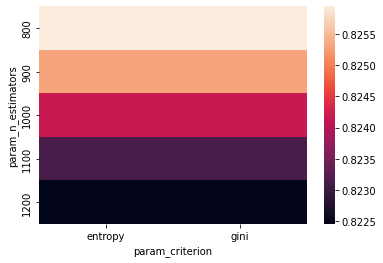

In [29]:
table = pd.pivot_table(pd.DataFrame(gs.cv_results_),
                       values = 'mean_test_score', index='param_n_estimators',
                       columns='param_criterion')

sns.heatmap(table)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

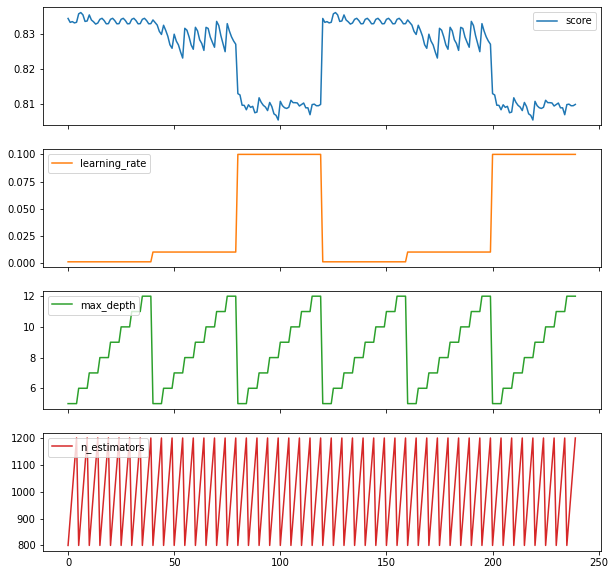

In [33]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True, figsize= (10, 10))               

### random search

탐색값에서 임위로 파라미터 값을 설정
그리드 서치의 문제점을 보완하기 위해 고안된 기법
구간 내 랜덤 조합을 사용하기 때문에 더 많은 지점을 살펴볼 수 있고, 불필요한 반복 탐색이 줄어 그리드 서치보다 탐색 속도가 빠름

In [35]:
from sklearn.model_selection import RandomizedSearchCV

In [38]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}
model = LGBMClassifier(random_state=random_state)

rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)

In [39]:
pred = rs.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

0.8755469755469755

In [40]:
pred = rs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[96  9]
 [28 46]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       105
           1       0.84      0.62      0.71        74

    accuracy                           0.79       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

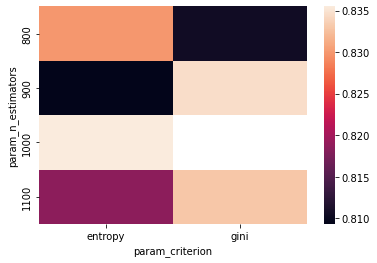

In [41]:
table = pd.pivot_table(pd.DataFrame(rs.cv_results_),
                       values = 'mean_test_score', index='param_n_estimators',
                       columns='param_criterion')

sns.heatmap(table)

In [43]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=rs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()

ax = scores_df.plot()
ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

NameError: ignored

# bayasian code

In [36]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.1 MB/s eta 0:00:00


In [46]:
import optuna
from sklearn.model_selection import cross_val_score

# TPESampler

In [47]:
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

In [48]:
class Objective:
    def __init__(self,x_train,y_train,seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
        self.cv = KFold(n_splits=num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",2,5),
            "min_samples_split" : trial.suggest_int("min_samples_split",2,5),
            "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
            "n_estimators" : trial.suggest_int("n_estimators",10,500,50),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
        }
        model = LGBMClassifier(random_state=self.seed,**hp)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring="roc_auc")
        return np.mean(scores)

In [49]:
sampler = TPESampler(seed=random_state) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler
)
objective = Objective(X_tr,y_tr,random_state)
study.optimize(objective,n_trials=50)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

Best Score: 0.8544399928115755
Best hp {'max_depth': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'max_leaf_nodes': 6, 'n_estimators': 110, 'learning_rate': 0.058907446212311886}


In [50]:
model = LGBMClassifier(random_state=random_state, **study.best_params)
model.fit(X_tr,y_tr)

pred = model.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

0.8902831402831403

In [51]:
optuna.visualization.plot_param_importances(study)

In [52]:
optuna.visualization.plot_optimization_history(study)